In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
output_notebook()

Loading BokehJS ...

### Read Dataset

In [2]:
well = pd.read_csv("Well-F12.csv")
well["DATEPRD"] = [datetime.datetime.strptime(x,"%Y-%m-%d").date() for x in well['DATEPRD']]
well

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2008-02-12,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,11.50,308.056,...,%,106.806,16.295,92.475,285,38889,385,NaN,production,OP
1,2008-02-13,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,24.00,303.034,...,%,120.889,53.374,89.620,1870,285246,7,NaN,production,OP
2,2008-02-14,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,22.50,295.586,...,%,113.718,72.738,80.120,3124,509955,1,NaN,production,OP
3,2008-02-15,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,23.15,297.663,...,%,116.831,69.996,84.251,2608,383427,1,NaN,production,OP
4,2008-02-16,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,24.00,295.936,...,%,115.434,71.518,82.359,3052,418474,5,NaN,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,2013-07-03,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,24.00,0.000,...,%,33.731,90.970,4.721,519,87111,4955,NaN,production,OP
1887,2013-07-04,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,24.00,0.000,...,%,33.709,91.031,4.798,525,86973,5170,NaN,production,OP
1888,2013-07-05,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,24.00,0.000,...,%,33.619,91.128,4.619,535,84968,5396,NaN,production,OP
1889,2013-07-06,NO 15/9-F-12 H,5599,15/9-F-12,3420717,VOLVE,369304,M�RSK INSPIRER,5.34,0.000,...,%,35.929,90.936,6.914,38,6685,440,NaN,production,OP


### Production Data Visualization and Feature Selection

The following is the production data obtained from one of the wells in VOLVE field, the oil production data (BORE_OIL_VOL) is the target feature for the forecasting while gas production (BORE_GAS_VOL), water production (BORE_WAT_VOL), and average wellhead pressure (AVG_WHP_P) will be the predictor.

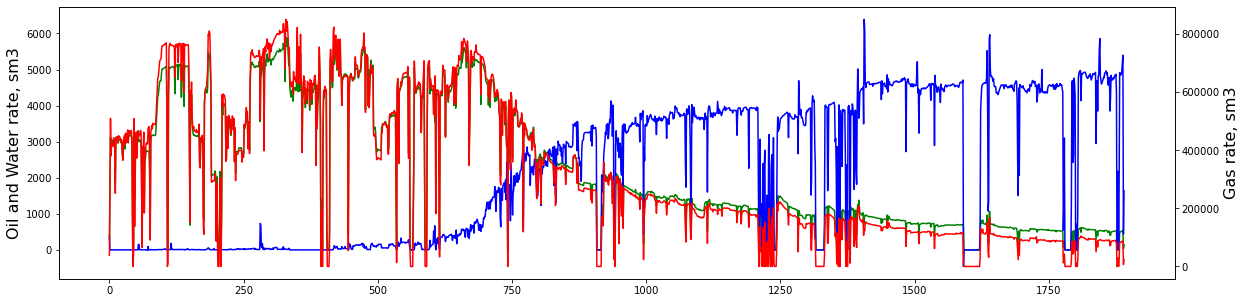

In [3]:
plt.rcParams["figure.figsize"] = (20,5)

oil = well.BORE_OIL_VOL
water = well.BORE_WAT_VOL
gas = well.BORE_GAS_VOL

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(oil, 'g-',label = "Oil rate")
ax1.plot(water,'b-',label ="Water rate")
ax2.plot(gas, 'r-',label = "Gas rate")

ax1.set_ylabel('Oil and Water rate, sm3',fontsize = 16)
ax2.set_ylabel('Gas rate, sm3',fontsize = 16)

plt.show()

In [4]:
well_clean = well[['DATEPRD','AVG_WHP_P','BORE_GAS_VOL','BORE_OIL_VOL','BORE_WAT_VOL']]

### Train, Validation, and Test Data Splitting

In [5]:
train = well_clean[well_clean.DATEPRD < pd.to_datetime("2012-05-26")]
val = well_clean[(well_clean.DATEPRD > pd.to_datetime("2012-05-25"))&(well_clean.DATEPRD <pd.to_datetime("2012-12-21"))]
test = well_clean[well_clean.DATEPRD > pd.to_datetime("2012-12-20")]

### Test data constraint setting

In [6]:
#pd.to_csv("Well-F12-TEST.csv"), dataset to alter for testing constraints
test = pd.read_csv("Well-F12-TEST.csv")

### Scale data with MinMaxScaler


In [7]:
f_columns = ['AVG_WHP_P',"BORE_GAS_VOL","BORE_WAT_VOL"]

f_transformer = MinMaxScaler()
target_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
target_transformer = target_transformer.fit(train[['BORE_OIL_VOL']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['BORE_OIL_VOL'] = target_transformer.transform(train[['BORE_OIL_VOL']])

val.loc[:, f_columns] = f_transformer.transform(val[f_columns].to_numpy())
val['BORE_OIL_VOL'] = target_transformer.transform(val[['BORE_OIL_VOL']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['BORE_OIL_VOL'] = target_transformer.transform(test[['BORE_OIL_VOL']])

C:\Users\IVAN\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-7-fac139a2c402>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['BORE_OIL_VOL'] = target_transformer.transform(train[['BORE_OIL_VOL']])
C:\Users\IVAN\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [8]:
train = train[['AVG_WHP_P','BORE_OIL_VOL',"BORE_GAS_VOL","BORE_WAT_VOL"]]
val = val[['AVG_WHP_P','BORE_OIL_VOL',"BORE_GAS_VOL","BORE_WAT_VOL"]]
test = test[['AVG_WHP_P','BORE_OIL_VOL',"BORE_GAS_VOL","BORE_WAT_VOL"]]

train_predictor = train[['AVG_WHP_P',"BORE_GAS_VOL",'BORE_WAT_VOL']]
val_predictor   = val[['AVG_WHP_P',"BORE_GAS_VOL",'BORE_WAT_VOL']]
test_predictor  = test[['AVG_WHP_P',"BORE_GAS_VOL",'BORE_WAT_VOL']]

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_predictor, train.BORE_OIL_VOL, time_steps)
X_val, y_val = create_dataset(val_predictor, val.BORE_OIL_VOL, time_steps)
X_test, y_test = create_dataset(test_predictor, test.BORE_OIL_VOL, time_steps)

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=128, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/40
11/11 [==============================] - 1s 80ms/step - loss: 0.1266 - val_loss: 0.0048
Epoch 2/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0809 - val_loss: 0.0474
Epoch 3/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0415 - val_loss: 0.0015
Epoch 4/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0261 - val_loss: 0.0043
Epoch 5/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0238 - val_loss: 0.0014
Epoch 6/40
11/11 [==============================] - 0s 19ms/step - loss: 0.0234 - val_loss: 0.0014
Epoch 7/40
11/11 [==============================] - 0s 18ms/step - loss: 0.0219 - val_loss: 0.0015
Epoch 8/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0212 - val_loss: 0.0014
Epoch 9/40
11/11 [==============================] - 0s 19ms/step - loss: 0.0215 - val_loss: 0.0012
Epoch 10/40
11/11 [==============================] - 0s 17ms/step - loss: 0.0209 - val_loss: 0.0013
Epoch 11/

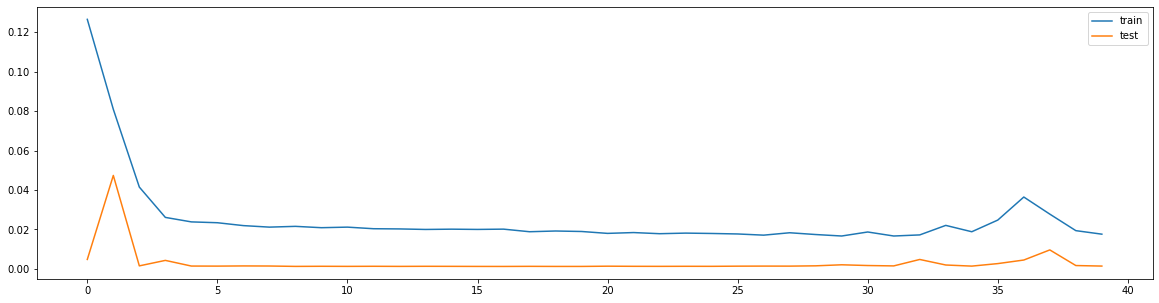

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend()

In [14]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

### Inverse Transform

In [15]:
y_train_pred_inv = target_transformer.inverse_transform(y_train_pred.reshape(1, -1))
y_train_inv = target_transformer.inverse_transform(y_train.reshape(1, -1))

y_val_pred_inv = target_transformer.inverse_transform(y_val_pred.reshape(1, -1))
y_val_inv = target_transformer.inverse_transform(y_val.reshape(1, -1))

y_test_pred_inv = target_transformer.inverse_transform(y_test_pred.reshape(1, -1))
y_test_inv = target_transformer.inverse_transform(y_test.reshape(1, -1))

In [16]:
#error
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_val_pred_inv.flatten(),y_val_inv.flatten()))

242.79485414124107

### Prediction vs Actual Data Result

In [24]:
xs = [np.arange(0, len(y_train)),np.arange(0, len(y_train)),np.arange(len(y_train), len(y_train) + len(y_val)),np.arange(len(y_train), len(y_train) + len(y_val)),np.arange(len(y_train)+len(y_val), len(y_train) + len(y_val) + len(y_test))]
ys = [y_train_inv.flatten(),y_train_pred_inv.flatten(),y_val_inv.flatten(),y_val_pred_inv.flatten(),y_test_pred_inv.flatten()]


line_color = ['red','blue','green','blue','black']


plot = figure(title="Oil prod rate vs days",plot_width=900,plot_height=400,x_axis_label="Day",y_axis_label="Oil Rate(sm3)")

plot.multi_line(xs, ys, line_color = line_color)
show(plot)